In [1]:
import numpy as np

# from PIL import Image

import torch
import torchvision
from torchvision import transforms

# import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.LinearParallel import outer_self as Outer # outer product v v^T of a vector with itself
#from agd.Plotting import savefig, quiver; #savefig.dirName = 'Figures/Riemannian'
#from agd import LinearParallel as lp
# from agd import AutomaticDifferentiation as ad

import time


from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt


from utils.OrientationScore import gaussian_OS, compact_OS, Cake_OS


from utils.dataset import ULMDataset, IOSTARDataset


from nn.ulm_unet import ULM_UNet

from skimage.filters import frangi

try:
    from utils.transforms import Rescale, RandomCrop, ToTensor, HeatMap, Rescale_image, ColorJitter, GlobalContrastNormalization, RandomAffine, Padding, CenterCrop, ToArray
except:
    from transforms import Rescale, RandomCrop, ToTensor, HeatMap, Rescale_image, ColorJitter, GlobalContrastNormalization, RandomAffine, Padding, CenterCrop, ToArray
    
import networkx as nx

import sys
sys.path.append("./../ULM_data")

/home/tbertrand/anaconda3/envs/ULM_landmark/lib/python3.8/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(


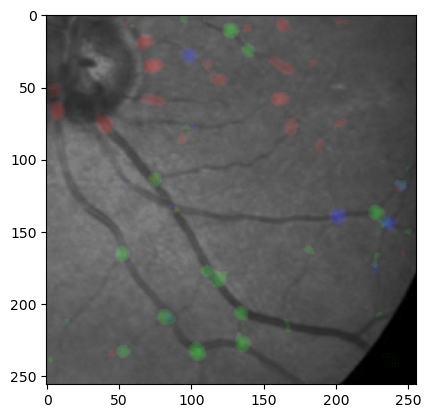

In [2]:
validation_dataset = IOSTARDataset(root_dir =  './data_IOSTAR/test_images', transform=transforms.Compose([RandomCrop(256), GlobalContrastNormalization(), HeatMap(s=9, alpha=3, out_channels = 4), ToTensor(), Padding(0)])) 
batch = validation_dataset[12]

im_tensor = batch['image'].unsqueeze(0)

model = ULM_UNet(in_channels=3, init_features=64, threshold = 0.15, out_channels = 4)
model.load_state_dict(torch.load('./weights/ulm_net_IOSTAR_epochs_1000_size_256_batch_4_out_channels_4_alpha_3.555774513043065_18_9_NoEndpoints_0.pt'))
Nt = 32

output = model(im_tensor)

plt.figure(0)
plt.imshow(im_tensor[0,0,:,:].detach().numpy(), cmap = 'gray')
plt.imshow((output[0,:-1,:,:].permute([1,2,0]).detach().numpy())*((output[0,:-1,:,:].permute([1,2,0]).detach().numpy()>0.15)+0.), cmap = 'jet', alpha = 0.5)

/tmp/ipykernel_65919/1760239586.py:7: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  frangi_lambda = lambda x: frangi(x, beta=param_beta, scale_range=scale, scale_step=step, alpha=param_alpha)


tensor(0)


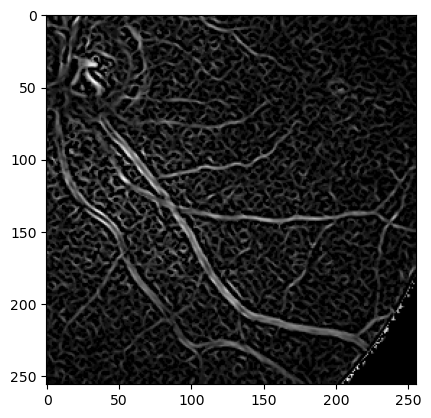

In [3]:
param_beta = .5
param_alpha = 0.5
im_tensor=im_tensor.squeeze()
scale = (.01,1)
step = 0.01

frangi_lambda = lambda x: frangi(x, beta=param_beta, scale_range=scale, scale_step=step, alpha=param_alpha)

A = np.array([frangi_lambda(im_tensor[0].numpy()), frangi_lambda(im_tensor[1].numpy()), frangi_lambda(im_tensor[2].numpy())])*(im_tensor.mean(dim=0)>0.05).numpy()
A = torch.tensor(A/A.max(axis=(1,2), keepdims=True)).max(dim=0).values**0.5

print(A.isnan().sum())

plt.imshow(A, cmap = 'gray',vmin=0.,vmax=1.)

In [4]:
# lifted_im_array = gaussian_OS(A, sigma = 0.01, eps = 0.1, N_o = Nt)
lifted_im_array = Cake_OS(A, No = Nt).permute([1,2,0]).numpy()

print(np.isnan(lifted_im_array).sum())  

# print((lifted_im_array[...,0]*lifted_im_array[...,32]).mean()/(lifted_im_array.max(axis=2)**2).mean())

# plt.figure(0)
# plt.imshow(lifted_im_array[...,0]>0.2, cmap = 'gray',vmin=0.,vmax=1.)

# plt.figure(1)
# plt.imshow(lifted_im_array[...,32]>0.2, cmap = 'gray',vmin=0.,vmax=1.)

# import napari
# napari.view_image(np.abs(lifted_im_array)**0.5, rgb=False)
# napari.run()

tensor([0.1953, 0.1975, 0.1997, 0.2019, 0.2041, 0.2064, 0.2086, 0.2109, 0.2133,
        0.2156, 0.2180, 0.2204, 0.2229, 0.2253, 0.2278, 0.2304, 0.2329, 0.2355,
        0.2381, 0.2407, 0.2434, 0.2461, 0.2488, 0.2516, 0.2543, 0.2571, 0.2600,
        0.2629, 0.2658, 0.2687, 0.2717, 0.2747, 0.2777, 0.2808, 0.2839, 0.2871,
        0.2902, 0.2934, 0.2967, 0.3000, 0.3033, 0.3066, 0.3100, 0.3135, 0.3169,
        0.3204, 0.3240, 0.3276, 0.3312, 0.3349, 0.3386, 0.3423, 0.3461, 0.3499,
        0.3538, 0.3577, 0.3617, 0.3657, 0.3697, 0.3738, 0.3779, 0.3821, 0.3864,
        0.3906])


/home/tbertrand/anaconda3/envs/ULM_landmark/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484747997/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/tbertrand/Bureau/ULM_4channel_pull/utils/OrientationScore.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I = torch.tensor(Im).float() +0.j


0


torch.Size([42, 3])


/tmp/ipykernel_65919/2775434752.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_tensor = torch.tensor(points).long()


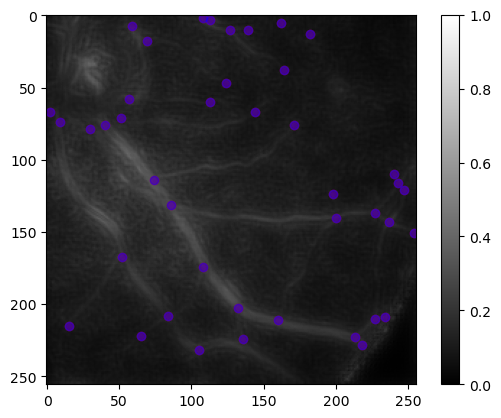

In [5]:
# plt.imshow((lifted_im_array/((lifted_im_array>0.1 + 0.)*lifted_im_array.max(axis=2, keepdims=True) + (1.-(lifted_im_array>0.2+0.)))).mean(axis=2), cmap='gray', vmin=0., vmax=1.)

plt.imshow(((lifted_im_array)**0.5).mean(axis=2), cmap='gray', vmin=0., vmax=1.)
plt.colorbar()

# W = (lifted_im_array/((lifted_im_array>0.1 + 0.)*lifted_im_array.max(axis=2, keepdims=True) + (1.-(lifted_im_array>0.2+0.)))).mean(axis=2).T


from HFM_computations import Modify_Metric_and_Points, Detection_Model, Show_Curves, Compute_Distance_Matrix

points_th = batch['landmarks']
points_th = points_th[points_th[:,0]>0]
print(points_th.shape)

# points = Detection_Model(model, batch, threshold=0.15)
points = points_th

points_tensor = torch.tensor(points).long()

plt.scatter(points_tensor[:,1], points_tensor[:,0], c='r', alpha=0.5)
plt.scatter(points_th[:,1], points_th[:,0], c='b', alpha=0.5)  

theta_indices = torch.tensor(lifted_im_array)[[points_tensor[:,1],points_tensor[:,0]]].argmax(dim=1)

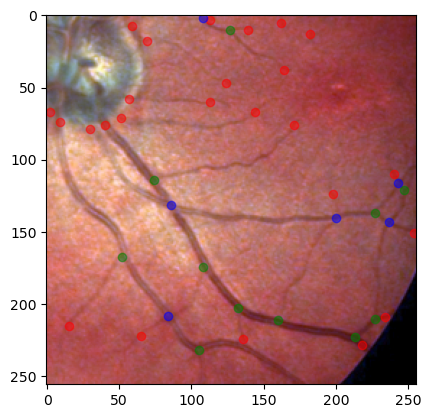

In [6]:
plt.imshow(im_tensor.permute([1,2,0]), cmap='gray')
plt.scatter(points_th[:,1][points_th[:,2]==0], points_th[:,0][points_th[:,2]==0], c='r', alpha=0.5)  
plt.scatter(points_th[:,1][points_th[:,2]==1], points_th[:,0][points_th[:,2]==1], c='g', alpha=0.5)  
plt.scatter(points_th[:,1][points_th[:,2]==2], points_th[:,0][points_th[:,2]==2], c='b', alpha=0.5)  



In [7]:
shift = 1e-8
[Ad, points_tensor_mod, theta_indices_mod] = Modify_Metric_and_Points(torch.tensor(lifted_im_array).permute([1,0,2]), points_tensor, theta_indices)

# W = Ad*(Ad*(Ad>0.05)) + 0. # for  ULM

W = Ad/Ad.max()

print(torch.isnan(torch.tensor(lifted_im_array)).sum())
    
points_array_3d = np.hstack([points_tensor_mod[:,:-1], theta_indices_mod.unsqueeze(1)])

nombre de points : 48
tensor(0)


In [8]:
# import napari
# # napari.view_image(W.numpy())
# viewer = napari.view_image(W.abs().sqrt().numpy())
# viewer.add_points(points_array_3d[:,[1,0,2]], face_color = 'r', size = 3)
# napari.run()

In [14]:
#%% Distance computation

[D, L, hfmIn] = Compute_Distance_Matrix(1/(1+1000*W**4), points_tensor_mod, theta_indices_mod, alpha=1., xi=1.)     



256 256 16


  2%|▏         | 1/47 [00:01<01:12,  1.58s/it]

Tip {0.640625,0.148438,0.981748} yields 6 restarts, geodesicVolumeBound increased to 18.5647

  4%|▍         | 2/47 [00:03<01:11,  1.59s/it]

Tip {0.484375,0.183594,2.35619} yields 7 restarts, geodesicVolumeBound increased to 24.134Tip {0.5625,0.261719,2.35619} yields 6 restarts, geodesicVolumeBound increased to 18.5647

  6%|▋         | 3/47 [00:04<01:08,  1.56s/it]

Tip {0.328125,0.8125,0.981748} yields 8 restarts, geodesicVolumeBound increased to 31.3743

  9%|▊         | 4/47 [00:06<01:07,  1.56s/it]

Tip {0.421875,0.0078125,0.392699} yields 7 restarts, geodesicVolumeBound increased to 24.134

 11%|█         | 5/47 [00:07<01:05,  1.56s/it]

Tip {0.421875,0.0078125,0.392699} yields 7 restarts, geodesicVolumeBound increased to 24.134

 13%|█▎        | 6/47 [00:09<01:04,  1.58s/it]

Tip {0.484375,0.183594,2.35619} yields 6 restarts, geodesicVolumeBound increased to 18.5647Tip {0.949219,0.453125,2.55254} yields 6 restarts, geodesicVolumeBound increased to 18.5647

 15%|█▍        | 7/47 [00:11<01:03,  1.59s/it]

Tip {0.667969,0.296875,0.981748} yields 6 restarts, geodesicVolumeBound increased to 18.5647

 17%|█▋        | 8/47 [00:12<01:01,  1.59s/it]

Tip {0.441406,0.234375,0.981748} yields 6 restarts, geodesicVolumeBound increased to 18.5647Tip {0.667969,0.296875,0.981748} yields 6 restarts, geodesicVolumeBound increased to 18.5647Tip {0.949219,0.453125,0.981748} yields 6 restarts, geodesicVolumeBound increased to 18.5647

 21%|██▏       | 10/47 [00:15<00:59,  1.60s/it]

Tip {0.949219,0.453125,0.981748} yields 8 restarts, geodesicVolumeBound increased to 31.3743Tip {0.78125,0.546875,1.9635} yields 8 restarts, geodesicVolumeBound increased to 31.3743

 26%|██▌       | 12/47 [00:18<00:55,  1.58s/it]

Tip {0.773438,0.484375,0.785398} yields 8 restarts, geodesicVolumeBound increased to 31.3743

 28%|██▊       | 13/47 [00:20<00:53,  1.58s/it]

Tip {0.53125,0.875,1.9635} yields 7 restarts, geodesicVolumeBound increased to 24.134Tip {0.421875,0.679688,0.392699} yields 7 restarts, geodesicVolumeBound increased to 24.134

 32%|███▏      | 15/47 [00:23<00:49,  1.55s/it]

Tip {0.949219,0.453125,2.55254} yields 7 restarts, geodesicVolumeBound increased to 24.134

 36%|███▌      | 17/47 [00:26<00:45,  1.52s/it]

Tip {0.773438,0.484375,0.785398} yields 9 restarts, geodesicVolumeBound increased to 40.7865

 38%|███▊      | 18/47 [00:28<00:43,  1.51s/it]

Tip {0.773438,0.484375,0.785398} yields 7 restarts, geodesicVolumeBound increased to 24.134

 40%|████      | 19/47 [00:29<00:41,  1.47s/it]

Tip {0.773438,0.484375,0.785398} yields 10 restarts, geodesicVolumeBound increased to 53.0225

 43%|████▎     | 20/47 [00:30<00:39,  1.48s/it]

Tip {0.78125,0.546875,1.9635} yields 6 restarts, geodesicVolumeBound increased to 18.5647

 45%|████▍     | 21/47 [00:32<00:36,  1.41s/it]

Tip {0.335938,0.511719,0.589049} yields 9 restarts, geodesicVolumeBound increased to 40.7865

 51%|█████     | 24/47 [00:36<00:31,  1.39s/it]

Tip {0.335938,0.511719,0.589049} yields 6 restarts, geodesicVolumeBound increased to 18.5647

 83%|████████▎ | 39/47 [00:57<00:10,  1.35s/it]

Tip {0.78125,0.546875,0.785398} yields 6 restarts, geodesicVolumeBound increased to 18.5647

100%|██████████| 47/47 [01:07<00:00,  1.43s/it]


Nombre de clusters etablis :16


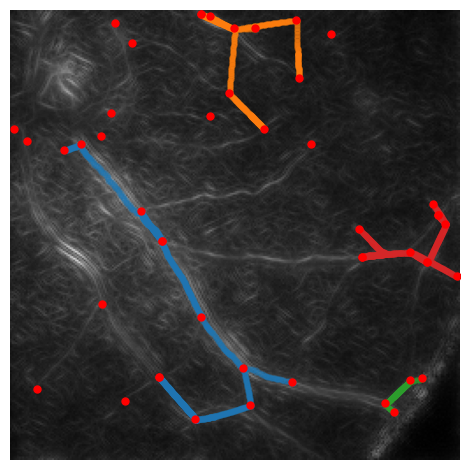

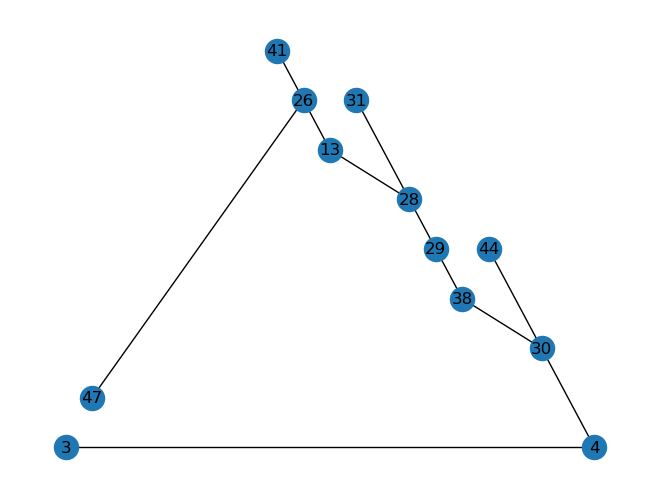

In [18]:
#%% Visualization
from HFM_computations import Cluster_from_Distance, Show_Tree
import napari

curves, list_of_stacks, Tcsr_list, prim_dict, labels = Cluster_from_Distance(D, L, distance_threshold=.15)
Show_Curves(W**0.5, im_tensor, points_tensor_mod, list_of_stacks, show_metric=True)
Show_Tree(Tcsr_list[0], labels, prim_dict)

#%%
points_array_3d = np.hstack([points_tensor_mod[:,:-1], theta_indices_mod.unsqueeze(1)])

[Nx,Ny] = im_tensor.shape[1:]


In [11]:

# viewer = napari.view_image((W).numpy())
# viewer.add_points(points_array_3d[:,[1,0,2]], face_color = 'r', size = 3)
# for i in range(len(list_of_stacks)):
#     stacked_list = list_of_stacks[i]
#     viewer.add_points(hfmIn.IndexFromPoint(stacked_list[:,::5].T)[0], face_color='b', size=1)